# Read Encoder from Motor via Serial

In [2]:
try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install serial
        import serial

import time, csv, os, requests
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
# use with Motor_PWM_Enc.ino
# 0.5 to 6 Hz linear chirp in 10s  N = 100000

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 40 kB 7.1 MB/s eta 0:00:011
     |████████████████████████████████| 192 kB 7.2 MB/s eta 0:00:01
  Using cached future-0.18.2.tar.gz (829 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=349459bf1fd8e3a43a2d042d8b340b4ac2ac2e0abcd72d500618d9f7c231e263
  Stored in directory: /Users/jonathanhow/Library/Caches/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# Initialize 
t = []
RPM = []
V1 = []
V5 =[]
Encoder = []
N = 10000

In [4]:
# See if Teensy present or load data if that exists
try:
    ser = serial.Serial('/dev/tty.usbmodem56064601')
    ser.flushInput()

    # sum will treat Boolean True as a 1, False as a 0
    n = sum(os.path.isfile(name) for name in os.listdir('.'))
    file_name = "Encoder_data_%s.cvs" % n 
    print(file_name)


    for jj in np.arange(N):
        ser_byte = ser.readline()
        decoded_bytes = ser_byte.decode('ascii').split(',')
        dt = float(decoded_bytes[0])
        dRPM = float(decoded_bytes[1])
        dV1 = float(decoded_bytes[2])
        dV5 = float(decoded_bytes[3])
        dEncoder = float(decoded_bytes[4])

        t.append(dt)
        RPM.append(dRPM)
        V1.append(dV1)
        V5.append(dV5)
        Encoder.append(dEncoder)

        with open(file_name, "a+", newline='') as file:
          writer = csv.writer(file, delimiter=',')
          writer.writerow([dt, dRPM, dV1, dV5, dEncoder])

        t = np.array(t)
        t -= t[0]    

except:
    try:
        url = 'https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/data/Encoder_data_20.cvs'
        url = 'https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/data/Encoder_data_112.cvs'
        download = requests.get(url).text.split("\r\n")
        for line in download:
            row = line.strip().split(',')
            if len(row) >= 4:
                t.append(float(row[0]))
                RPM.append(float(row[1]))
                V1.append(float(row[2]))
                V5.append(float(row[3]))
                if len(row) == 5:
                    Encoder.append(float(row[4]))
                else:
                    Encoder.append(float(0.0))


        if (0): # local file
            with open("Encoder_data_20.cvs", 'r') as file:
                reader = csv.reader(file)   
                for row in reader:
                    t.append(float(row[0]))
                    RPM.append(float(row[1]))
                    V1.append(float(row[2]))
                    V5.append(float(row[3]))
                    Encoder.append(float(row[4]))

        print("Loaded recorded data")
        t = np.array(t)
        t -= t[0]    
    except:
        print("No data")

Loaded recorded data


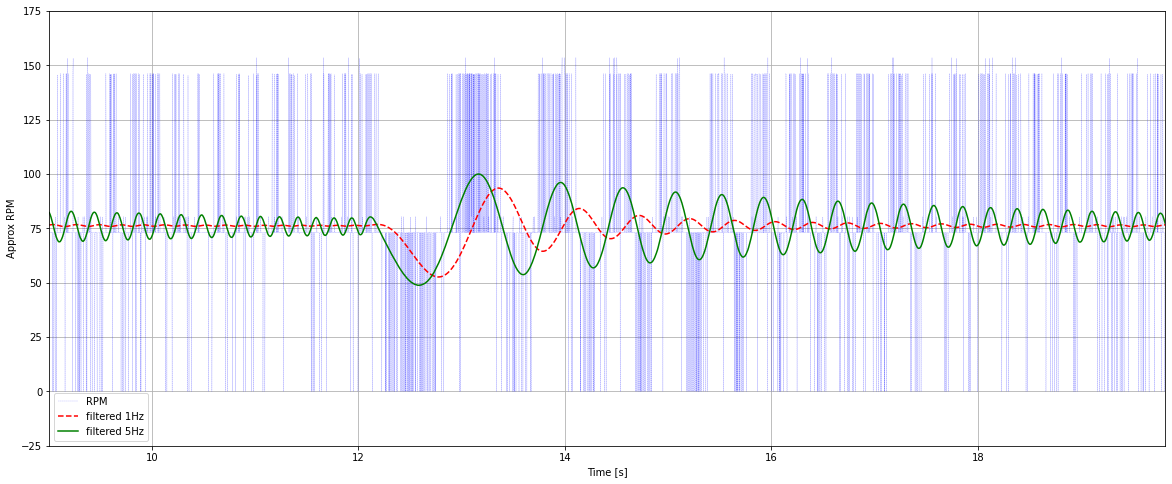

In [5]:
# parts to plot
Nlow = 4500
Nhigh = N-100 

fig, ax = plt.subplots()
ax.plot(t[Nlow:Nhigh],RPM[Nlow:Nhigh],'b:',lw=0.25)
ax.plot(t[Nlow:Nhigh],V1[Nlow:Nhigh],'r--')
ax.plot(t[Nlow:Nhigh],V5[Nlow:Nhigh],'g-')
ax.set_xlim(t[Nlow], t[Nhigh])
ax.set_ylim(-25, 175)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Approx RPM')
plt.legend(['RPM','filtered 1Hz','filtered 5Hz'])
plt.grid()
plt.show()
fig.savefig('./data/response1.png', dpi=300)


## Plot Raw encoder rate compared to filtered values

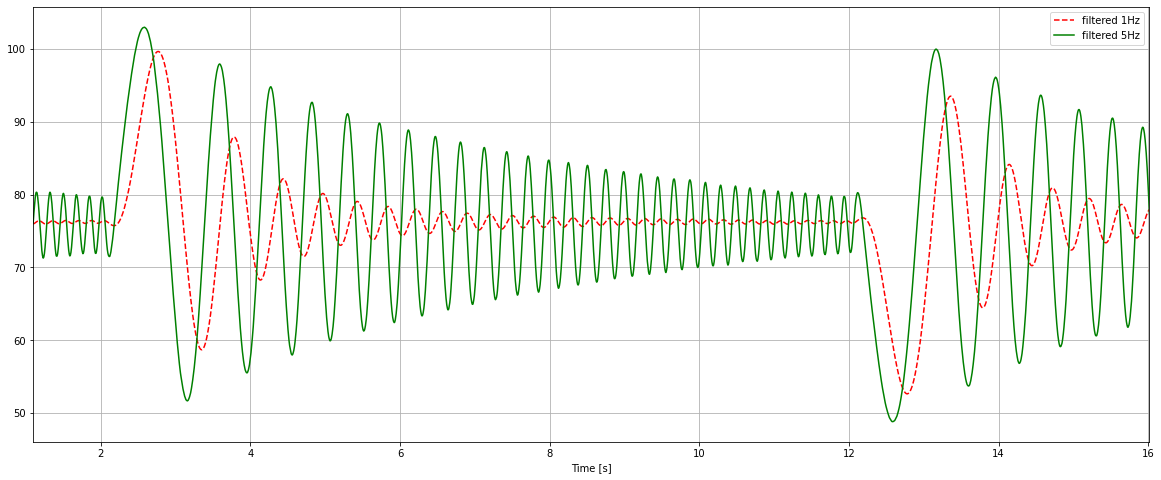

In [6]:
fig, ax = plt.subplots()

ax.plot(t,V1,'r--')
ax.plot(t,V5,'g-')

Nlow = 550
Nhigh = 8000
ax.set_xlim(t[Nlow], t[Nhigh])

#ax.set_ylim(40, 120)
plt.legend(['filtered 1Hz','filtered 5Hz'])
ax.set_xlabel('Time [s]')
plt.grid()
plt.show()
fig.savefig('./data/response2.png', dpi=300)


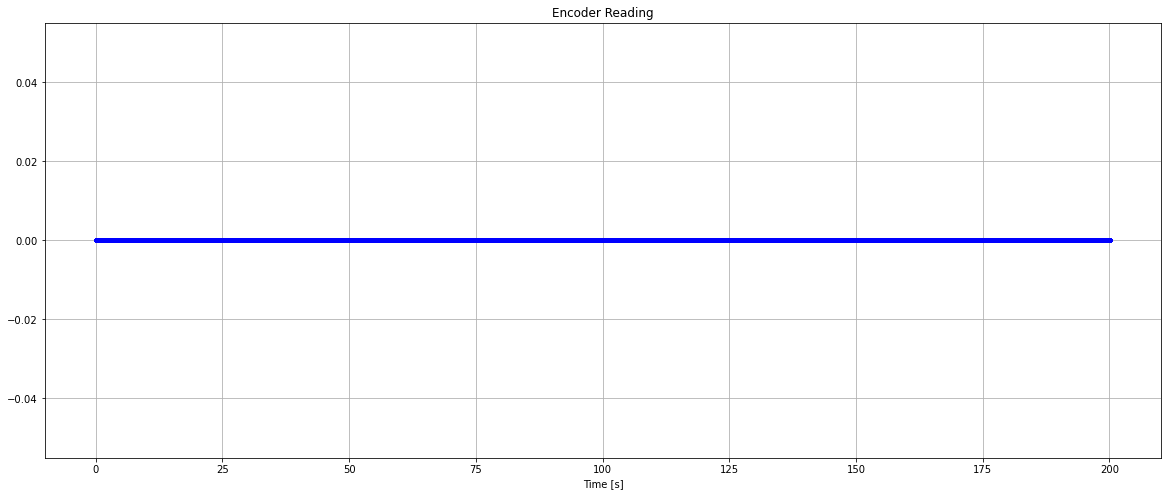

In [7]:
# Check Encoder
fig, ax = plt.subplots()

ax.plot(t,Encoder,'b.')

Nlow = 750
Nhigh = 800
#ax.set_ylim(4000, 4400)
#ax.set_xlim(t[Nlow], t[Nhigh])
ax.set_xlabel('Time [s]')
plt.title('Encoder Reading')
plt.grid()
plt.show()
fig.savefig('./data/encoder.png', dpi=300)


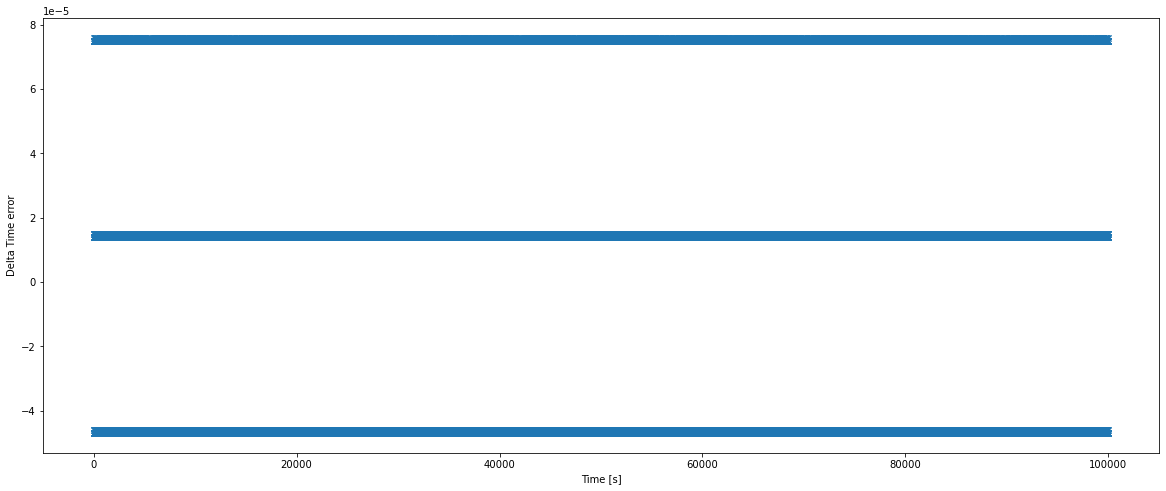

In [8]:
# check timing
printtime = 2000e-6 # in teensy code
fig, ax = plt.subplots()
plt.plot(np.diff(t) - printtime,'x')
ax.set_ylabel('Delta Time error')
ax.set_xlabel('Time [s]')
plt.show()
fig.savefig('./data/timing.png', dpi=300)
